In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model, standardize_dataset
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, MLP
from dev_losses import cauchy, rbf, gaussian_kernel, CustomSupCon, CustomContrastiveLoss
from losses import KernelizedSupCon

In [2]:
def gaussian_kernel(x, krnl_sigma = 0.1):
    kernelized = []
    for var in x.T:
        krnl_var = var.unsqueeze(-1).T - var.unsqueeze(-1)
        kernelized.append(krnl_var)
    kernelized = sum([krnl_var**2 for krnl_var in kernelized])
    return torch.exp(-kernelized / (2*(krnl_sigma**2))) / (math.sqrt(krnl_sigma*torch.pi)*krnl_sigma)

In [3]:
!pwd

/gpfs3/well/margulies/users/cpy397/contrastive-learning


In [4]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
dataset = MatData("vectorized_matrices_la5c.npy", "hopkins_covars.npy")

In [95]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size = 0.2, random_state=42) #train_size = 5
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [96]:
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str, krnl_sigma = None, temperature: float=0.07, contrast_mode: str='all',
                 base_temperature: float=0.07, kernel: callable=None, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.delta_reduction = delta_reduction
        self.krnl_sigma = krnl_sigma

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction}, ' \
               f'krnl_sigma={self.krnl_sigma}'
                

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features]. 
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError('`features` needs to be [bsz, n_views, n_feats],'
                             '3 dimensions are required')

        batch_size = features.shape[0]
        n_views = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)
        
        else:
            # labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError(f'Num of labels does not match num of features: {labels.shape[0]} vs. {batch_size}')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, self.krnl_sigma)
            
        view_count = features.shape[1]
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            features = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            features = features
            anchor_count = view_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # Tile mask
        mask = mask.repeat(anchor_count, view_count)

        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size*n_views, device=device).view(-1, 1),
            0
        )

        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T),
            self.temperature
        )
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        alignment = logits 

        # base case is:
        # - supcon if kernel = none 
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal 

        if self.method == 'threshold':
            repeated = mask.unsqueeze(-1).repeat(1, 1, mask.shape[0]) # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(1, 2) # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])

            if self.delta_reduction == 'mean':
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)
    
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))
        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = alignment - uniformity # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # compute mean of log-likelihood over positive
 
        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()

    

In [119]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
input_dim_target = 60
# the rest is arbitrary
hidden_dim_feat = 1000
hidden_dim_target = 30
output_dim = 2

num_epochs = 100

temperature = 0.07
base_temperature = 0.07 # too low values return nan loss

lr = 0.01 # too low values return nan loss
kernel = gaussian_kernel
batch_size = 5 # too low values return nan loss
dropout_rate = 0

In [120]:
def gaussian_kernel(x, krnl_sigma = 10):
    kernelized = []
    for var in x.T:
        krnl_var = var.unsqueeze(-1).T - var.unsqueeze(-1)
        kernelized.append(krnl_var)
    kernelized = sum([krnl_var**2 for krnl_var in kernelized])
    return torch.exp(-kernelized / (2*(krnl_sigma**2))) / (math.sqrt(krnl_sigma*torch.pi)*krnl_sigma)

In [ ]:
standardized_train_dataset = standardize_dataset(train_dataset)
std_train_loader = DataLoader(standardized_train_dataset, batch_size=batch_size, shuffle=True)

standardized_test_dataset = standardize_dataset(test_dataset)
std_test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [172]:
torch.cuda.empty_cache()
model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim, dropout_rate = 0).to(device)
criterion_pft = KernelizedSupCon(method='expw', temperature=1, base_temperature=1, kernel=kernel, krnl_sigma = 10)
criterion_ptt = KernelizedSupCon(method='expw', temperature=5, base_temperature=5, kernel=kernel, krnl_sigma = 5)

# criterion = CustomKernelizedSupCon(temperature = temperature, base_temperature = base_temperature, kernel = kernel)
# criterion = CustomSupCon('exp',temperature = temperature, base_temperature = base_temperature, kernel = kernel)

optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(std_train_loader):
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        out_feat, out_target = model(features, targets)
        loss = criterion_pft(out_feat.unsqueeze(1), targets)
        loss += criterion_ptt(out_target.unsqueeze(1), targets)
        loss += torch.nn.functional.mse_loss(out_feat, out_target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        batch_losses.append(loss.item())
        optimizer.step()
    print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')


mape_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'mape')
r2_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'r2')
# results_cv.append(['Overall', mape_train, r2_train, mape_val, r2_val])
print(mape_train, r2_train)


Epoch 0 | Mean Loss 2.4841293573379515
Epoch 1 | Mean Loss 1.949931001663208
Epoch 2 | Mean Loss 1.5125928163528441
Epoch 3 | Mean Loss 1.4424650430679322
Epoch 4 | Mean Loss 1.409980058670044
Epoch 5 | Mean Loss 1.3905206203460694
Epoch 6 | Mean Loss 1.3910221815109254
Epoch 7 | Mean Loss 1.389836883544922
Epoch 8 | Mean Loss 1.3897409439086914
Epoch 9 | Mean Loss 1.3901603937149047
Epoch 10 | Mean Loss 1.3881892681121826
Epoch 11 | Mean Loss 1.3872150182724
Epoch 12 | Mean Loss 1.3871769905090332
Epoch 13 | Mean Loss 1.386087918281555
Epoch 14 | Mean Loss 1.386769962310791
Epoch 15 | Mean Loss 1.3852758646011352
Epoch 16 | Mean Loss 1.3862598419189454
Epoch 17 | Mean Loss 1.3867480039596558
Epoch 18 | Mean Loss 1.3864712953567504
Epoch 19 | Mean Loss 1.3843076705932618
Epoch 20 | Mean Loss 1.3835798263549806
Epoch 21 | Mean Loss 1.3831315279006957
Epoch 22 | Mean Loss 1.3850612878799438
Epoch 23 | Mean Loss 1.3880046367645265
Epoch 24 | Mean Loss 1.3785629510879516
Epoch 25 | Mean Lo

In [173]:
# results_df = pd.DataFrame(results_cv, columns=['Fold', 'Train_MAPE', 'Train_R2', 'Val_MAPE', 'Val_R2'])
# results_df.to_csv('cv_results_hopkins.csv', index=False)

## Testing

In [174]:
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# features = torch.vstack([test_dataset[i][0] for i in range(len(test_loader))])
# targets = torch.vstack([test_dataset[i][1] for i in range(len(test_loader))])
# features_mean, features_std, targets_mean, targets_std = compute_global_stats(test_dataset)
# standardized_features = (features - features_mean) / features_std
# standardized_targets = (targets - targets_mean) / targets_std
# standardized_test_dataset = TensorDataset(standardized_features, standardized_targets)
# test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [189]:
model.eval()
test_losses = []
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_test_loader):
        features = features.to(device).float()
        targets = targets.to(device)

        out_feat, out_target = model(features, targets)
        emb_features.append(out_feat.cpu())
        emb_targets.append(out_target.cpu())
        loss = criterion_pft(out_feat.unsqueeze(1), out_target)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   0.42


In [190]:
emb_features = torch.row_stack(emb_features)

In [191]:
emb_targets = torch.row_stack(emb_targets)

In [192]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [193]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [194]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
emb_features["Type"] = 'Features'
emb_targets["Type"] = 'Targets'


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

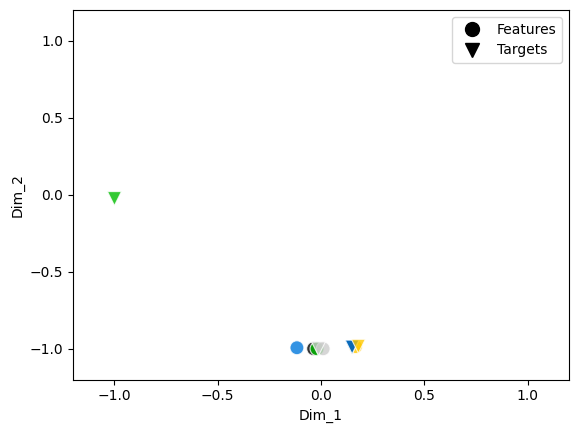

In [195]:
# time to cry
# I probably messed up the original loss. Went over it multiple times
import matplotlib.lines as mlines

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Features')
sns.scatterplot(emb_targets, x = 'Dim_1', marker = 'v', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Targets')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

feature_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Features')
target_handle = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='Targets')

plt.legend(handles=[feature_handle, target_handle])